In [2576]:
import pandas as pd
import os
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#print(os.getcwd())
path="/Users/atousachaharsoughshirazi/Capstone_two/data"
os.chdir(path)
file="bank-additional-full.csv"
df=pd.read_csv(file, sep=';', header=0)


# 1) Data wrangling

In [2577]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2578]:
df.shape

(41188, 21)

In [2579]:
#There is no null value in the data set but some are 'unknown'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [2580]:
#convert integers to float
df['age']=df['age'].astype(float)
df['previous']=df['previous'].astype(float)
df['duration']=df['duration'].astype(float)
df['campaign']=df['campaign'].astype(float)
df['pdays']=df['pdays'].astype(float)

In [2581]:
#number of unique values in each column
column_list = df.columns.values.tolist()
for column_name in column_list:
    print(column_name, df[column_name].nunique())

age 78
job 12
marital 4
education 8
default 3
housing 3
loan 3
contact 2
month 10
day_of_week 5
duration 1544
campaign 42
pdays 27
previous 8
poutcome 3
emp.var.rate 10
cons.price.idx 26
cons.conf.idx 26
euribor3m 316
nr.employed 11
y 2


### Column descriptions

#### Client info:

 1. age (numeric)
 2. job : type of job (categorical: 'admin.','blue collar', 'entrepreneur',  'housemaid', 'management', 'retired', 'selfemployed','services','student','technician','unemployed','unknown')
 3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means  divorced or widowed)
 4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course', 'university.degree','unknown')
 5. default: has credit in default? (categorical: 'no','yes','unknown')
 6. housing: has a housing loan? (categorical: 'no','yes','unknown')
 7. loan: has personal loan? (categorical: 'no','yes','unknown')
 
#### Related with the last contact of the current campaign:
 
 8. contact: contact communication type (categorical: 'cellular','telephone') 
 9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
 10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
 11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. *This feature will be dropped in the EDA section.*
 
#### Other attributes:
 
 12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
 13. pdays: number of days that passed by after the client was last contacted from a previous campaign. It is numeric; 999 means client was not previously contacted. 39673 cases of 999 are present. I replaced the '999' value with '-1'. After replacement the range of this variable is [-1, 27].

In [2582]:
df['pdays']=df['pdays'].replace(999, -1)

'pdays' column analysis: There are 35563 rows where ‘previous’ is 0, meaning that the client was not previously contacted. This automatically is associated with ‘pdays’=999 and ‘poutcome’=nonexistent. I confirmed that on the data. However, there are 39673 rows that have ‘pdays’=999. That shows that there are 4110 rows with pdays=999 (meaning that the customer was not previously contacted) but these rows have a ‘poutcome’ of either failure or success. That means for 4110 rows either the duration of the call was not recorded and they labeled them to 999 by mistake or the client has subscribed/not subscribed without being contacted by phone.

In [2583]:
dft=df[df['pdays']==-1]
dft['previous'].value_counts()

0.0    35563
1.0     3696
2.0      349
3.0       50
4.0       12
5.0        2
6.0        1
Name: previous, dtype: int64

 14. previous: number of contacts performed before this campaign and for this client (numeric)
 15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
 
#### Social and economic context attributes:
 
 16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
 17. cons.price.idx: consumer price index - monthly indicator (numeric). For every 'cons.price.idx' there is a unique  'cons.conf.idx'. So it is safe to drop one of these columns (analysis below). *This feature will be dropped in the EDA section.*
 18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 

In [2584]:
df['cons.price.idx' ].value_counts()

93.994    7763
93.918    6685
92.893    5794
93.444    5175
94.465    4374
93.200    3616
93.075    2458
92.201     770
92.963     715
92.431     447
92.649     357
94.215     311
94.199     303
92.843     282
92.379     267
93.369     264
94.027     233
94.055     229
93.876     212
94.601     204
92.469     178
93.749     174
92.713     172
94.767     128
93.798      67
92.756      10
Name: cons.price.idx, dtype: int64

In [2585]:
df['cons.conf.idx'].value_counts()

-36.4    7763
-42.7    6685
-46.2    5794
-36.1    5175
-41.8    4374
-42.0    3616
-47.1    2458
-31.4     770
-40.8     715
-26.9     447
-30.1     357
-40.3     311
-37.5     303
-50.0     282
-29.8     267
-34.8     264
-38.3     233
-39.8     229
-40.0     212
-49.5     204
-33.6     178
-34.6     174
-33.0     172
-50.8     128
-40.4      67
-45.9      10
Name: cons.conf.idx, dtype: int64

19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric). For every 'nr.employed' there is a unique 'emp.var.rate'. So it is safe to drop one of these columns (analysis below). *This feature will be dropped in the EDA section.*

In [2586]:
df['emp.var.rate'].value_counts()

 1.4    16234
-1.8     9184
 1.1     7763
-0.1     3683
-2.9     1663
-3.4     1071
-1.7      773
-1.1      635
-3.0      172
-0.2       10
Name: emp.var.rate, dtype: int64

In [2587]:
df['nr.employed'].value_counts()

5228.1    16234
5099.1     8534
5191.0     7763
5195.8     3683
5076.2     1663
5017.5     1071
4991.6      773
5008.7      650
4963.6      635
5023.5      172
5176.3       10
Name: nr.employed, dtype: int64

### Missing values
The result of exploring the columns with value_counts():

* There is no null value in the dataset but some are 'unknown' 
* jobs: 330 are unknown
* marital status: 80 are unknown
* education: 1731 are unknown
* default: 8597 are unknown. In this column there are only 3 'yes' values, the rest are either 'no' or unknown. (Drop?)
* housing: 990 are unknown
* loan: 990 are unknown (the same rows as the housing unknowns)
* all other columns have no unknown values



In [2588]:
column_list = df.columns.values.tolist()
for column_name in column_list:
    print(column_name,': \n', 
          df[column_name].value_counts())

age : 
 31.0    1947
32.0    1846
33.0    1833
36.0    1780
35.0    1759
        ... 
91.0       2
89.0       2
87.0       1
95.0       1
94.0       1
Name: age, Length: 78, dtype: int64
job : 
 admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
marital : 
 married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
education : 
 university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
default : 
 no         32588
unknown     8597
yes            3
Name: default, dtype: int64
housing : 
 yes        215

In [2589]:
dft=df[df['housing']=='unknown']
dft['loan'].value_counts()

unknown    990
Name: loan, dtype: int64

### Duplicates

In [2590]:
#There are 12 duplicate rows as can be seen from the analysis below and the profile report.
duplicateRowsDF = df[df.duplicated(keep=False)]
duplicateRowsDF
df=df.drop_duplicates(keep='first',ignore_index=True)
df.shape

(41176, 21)

In [2591]:
#report=df.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
#report

### Adding the 'year' column

We are trying to predict the outcome on column 'y', 'yes' means that the client subscribed to the loan and 'no' means that it didn't. According to the chart below there were more unsuccessful outcomes.
However, this result is for the years 2008-2010 combined. In order to see the effect of the contact month or year on the outcome we need to groupby the outcomes for each year and/or month. Thus, I need to add a 'year' column with values 2008, 2009 and 2010 for appropriate rows.

* Year 2008 starts on May (beginning of the dataset row 0) and ends on December.
* Year 2009 starts on March and ends on December.
* Year 2010 starts on March and ends on November(the last row of the dataset).

In the box below I find the ending index for each month. 
For the purpose of adding a 'year' column I only need to know which row December ends but it was interesting to find
the ending index for each month.

In [2592]:
month=list(df.month.unique())
for i in month:
    i_index=df[df['month']==i].index
    i_startindex=[]
    for j in range(len(i_index)-1):
        if (i_index[j+1]-i_index[j])>1:
            i_startindex.append(i_index[j])
            i_startindex.append(i_index[j+1])
       
    print(i, i_startindex)
    

may [7761, 30421, 36213, 39556]
jun [12135, 36214, 36928, 39768]
jul [18816, 36929, 37105, 39997]
aug [23989, 37106, 37875, 40308]
oct [24056, 38143, 38588, 40844]
nov [27671, 38589, 38945, 41048]
dec [27681, 38946]
mar [27963, 39118]
apr [30420, 39382]
sep [38142, 40541]


In order to add a 'year' column, I first added a column with values equal to 'month', then replaced them with proper values for the year. 
There may be a better way to do this, I will check out other ways to add a column!
Some months are missing for example year 2008 does not have any contacts for months of Jan-Apr and Sep. Year 2009 has contacts for March-December months, and year 2010 has March-November. By checking the head of the dataframe we can see that the 'year' has been added.


In [2593]:
df['year']=df['month' ]

df.iloc[0:27682,21]='2008'
df.iloc[27682:39119, 21]='2009'
df.iloc[39119:41176, 21]='2010'
df.head(-5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,year
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,-1.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2008
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,-1.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2008
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,-1.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2008
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,-1.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2008
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,...,-1.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41166,62.0,retired,married,university.degree,no,no,no,cellular,nov,thu,...,6.0,3.0,success,-1.1,94.767,-50.8,1.031,4963.6,yes,2010
41167,64.0,retired,divorced,professional.course,no,yes,no,cellular,nov,fri,...,-1.0,0.0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,2010
41168,36.0,admin.,married,university.degree,no,no,no,cellular,nov,fri,...,-1.0,0.0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,2010
41169,37.0,admin.,married,university.degree,no,yes,no,cellular,nov,fri,...,-1.0,0.0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,2010


We can see from the analysis below that the 'year' column is an object type. We change it to an integer.

In [2594]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  float64
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  float64
 11  campaign        41176 non-null  float64
 12  pdays           41176 non-null  float64
 13  previous        41176 non-null  float64
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [2595]:
df.year.astype('int64')

0        2008
1        2008
2        2008
3        2008
4        2008
         ... 
41171    2010
41172    2010
41173    2010
41174    2010
41175    2010
Name: year, Length: 41176, dtype: int64

### Binary outcome 

Finally we replace the 'yes' values in the 'y' column by 1 and the 'no' values by 0.

In [2596]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,year
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,-1.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2008
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,-1.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2008
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,-1.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2008
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,-1.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2008
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,...,-1.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2008


# 2) EDA

### Correlated variables

In [2597]:
#Calculate the correlation coefficients
#corr =df.corr()
#corr.round(2).style.background_gradient(cmap='coolwarm')

* From the heatmap above we can see that 'euribor3m' and 'emp.var.rate' are highly correlated so we drop one of them.

* We also drop the 'duration', 'cons.conf.idx', 'nr.employed variable (look at the data section above).

In [2598]:
df.drop(['duration','euribor3m','cons.conf.idx', 'nr.employed'], axis=1, inplace=True)
# corr =df.corr()

# corr.round(2).style.background_gradient(cmap='coolwarm')

In [2599]:
#sns.pairplot(df)

In [2600]:
#df1=df.set_index('month', 'y').groupby('month').mean()
#df1=df.set_index('month').groupby('month').count()
#df1
#df[df['y']=='yes']

In [2601]:
#sns.pairplot(df1)

In [2602]:
#plt.figure()
#sns.countplot(x='y', data=df, palette='RdBu')
#plt.xticks([0,1], ['No', 'Yes'])
#plt.show()


### Outcome by year

The first chart below is the countplot of the outcome for each year and the second chart shows the proportion of positive outcome for each year. 

In [2603]:
# plt.figure()
# sns_plot=sns.countplot(x='y', hue='year', data=df)
# plt.xticks([0,1], ['No', 'Yes'])
# plt.xlabel("Outcome")
# plt.show()
# fig = sns_plot.get_figure()
# fig.savefig('/Users/atousachaharsoughshirazi/Capstone_two/figures/targetcountplotbyyear.png') 

We can see that the number of 'yes' outcomes did not change much from 2008 to 2010. But the number of 'no' outcomes significantly decreased and in year 2010 there are almost the same number of yes/no outcomes.

In [2604]:
# dfy=df[['year','y']].set_index('year').groupby(by=['year'])
# dfy['y'].value_counts()
# palette=sns.color_palette("coolwarm", 7)

In [2605]:
# sns_plot=sns.barplot(x='year', y='y',data=df[['year','y']])
# sns_plot.set(ylabel='proportion of positive outcome')
# plt.show()
# fig = sns_plot.get_figure()
# fig.savefig('/Users/atousachaharsoughshirazi/Capstone_two/figures/targetbarplotbyyear.png') 
# palette=sns.color_palette("coolwarm", 7)
#palette='RdBu'

### Outcome by month and year

Some months are missing for example year 2008 does not have any contacts for months of Jan-Apr and Sep. Year 2009 has contacts for March-December months, and year 2010 has March-November.

In [2606]:
#dfn=df[['year','month','y']].set_index('year','month').groupby(by=['year','month'])
#dfn['y'].value_counts()
#dfn.head()

In [2607]:
#  sns_plot=sns.barplot(x='year', y='y', hue='month',data=df[['year','month','y']])
#  sns_plot.set(ylabel='proportion of positive outcome')
#  plt.show()
#  fig = sns_plot.get_figure()
#  fig.savefig('/Users/atousachaharsoughshirazi/Capstone_two/figures/targetbarplotbyyearandmonth.png') 

From the chart above we can see that in 2008 the proportion of positive outcomes in October (the purple bar) was much higher than other months. In 2009, May and April had the lowest proportion of positive outcomes and in 2010 all proportions for different months got closer to each other. This shows that the trend has changed significantly from 2008 to 2010. This data is during the economic crisis which could have affected the outcome trend dramatically. 

In [2608]:
#dfnn=dfn.set_index('month','year').groupby(by=['month', 'year'])
#dfnn['y'].value_counts()

#df1=df[['month','y']] 
#df2=df1.groupby('month')
#df2['y'].value_counts()

#df2=df1.replace({'y':{'yes':1 ,'no': 0 }})
#sns_plot=sns.barplot(x='month', y='y', data=df2)
#sns_plot.set(ylabel='percentage of positive outcome')
#plt.show()

#pd.to_numeric(df2.y)
#df3=pd.DataFrame(df2.groupby('month', sort=False).sum())
# df3.reindex()
#df3
# #plt.bar(x='month', height='y', hue='month', data=df3)
# #sns.swarmplot(x='month', y='y', data=df3)

#df1['month'].value_counts()

In [2609]:
# for i in df.columns.values:
#     dfi=df[[i ,'y']]
#     dfi2=dfi.replace({'y':{'yes':1 ,'no': 0 }})
#     pd.to_numeric(dfi2.y)
#     df3=pd.DataFrame(dfi2.set_index(i).groupby(i).sum().sort_values(by=['y'], ascending=False))
#     plt.bar(i,'y', data=df3)
#     plt.show()
#     #print(dfi2.set_index(i).groupby(i).sum().sort_values(by=['y'], ascending=False))
    
    


In [2610]:
# for i in df.columns.values:
#     dfi=df[[i ,'y']]
#     dfi2=dfi.replace({'y':{'yes':1 ,'no': 0 }})
#     sns.barplot(x=i, y='y', data=df2)
#     plt.show()



### Outcome by job

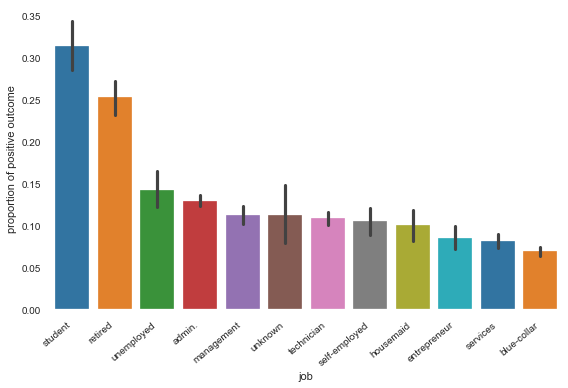

In [2611]:
sns_plot=sns.barplot(x='job', y='y', data=df[['job','y']], palette='tab10', order=df[['job', 'y']].groupby('job').mean().sort_values(by='y', ascending=False).index.values)
sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=40, ha="right")
sns_plot.set(ylabel='proportion of positive outcome')
plt.tight_layout()
plt.show()
fig = sns_plot.get_figure()
fig.savefig('/Users/atousachaharsoughshirazi/Capstone_two/figures/jobbarplotbyyear.png') 

In the chart above we can see that students and retirees have significantly higher proportions of positive outcomes.

### Outcome by education

In [2612]:
#order=['illiterate', 'basic.4y', 'basic.6y',
#       'basic.9y','high.school','professional.course','university.degree', 'unknown' ]

In [2613]:
# sns_plot=sns.barplot(x='education', y='y', data=df[['education','y']], order=order)
# sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=40, ha="right")
# sns_plot.set(ylabel='percentage of positive outcome')
# plt.tight_layout()
# plt.show()
# fig = sns_plot.get_figure()
# fig.savefig('/Users/atousachaharsoughshirazi/Capstone_two/figures/educationbarplotbyyear.png') 
# #, palette=sns.color_palette("coolwarm", 7)

### Outcome by housing

In [2614]:
# sns_plot=sns.barplot(x='housing', y='y', data=df[['housing','y']])
# sns_plot.set(ylabel='percentage of positive outcome')
# plt.show()
# fig = sns_plot.get_figure()
# fig.savefig('/Users/atousachaharsoughshirazi/Capstone_two/figures/housingbarplot.png')

In [2615]:
pd.DataFrame(df[['housing','y']].groupby('housing', sort=False).sum())

,y
housing,
no,2025
yes,2507
unknown,107


From 4639 total positive outcomes, 2507(or 54.04%) clients had a housing loan, 2025(43.65%) didn't have a housing loan and for 107 (2.3%) housing was unknown.

In [2616]:
df[['housing','y']].housing.value_counts()

yes        21571
no         18615
unknown      990
Name: housing, dtype: int64

From 21571 clients that had housing, 2507 of them subscribed. So the proportion of positive outcomes for clients with housing is 0.1162(or percentage of 11.62%). The proportion of positive outcome for clients with no housing is 0.1088 and with unknown housing is 0.108.

In [2617]:
# df1=df[['loan','y']]
# df2=df1.replace({'y':{'yes':1 ,'no': 0 }})

# sns_plot=sns.barplot(x='loan', y='y', data=df2)
# sns_plot.set(ylabel='percentage of positive outcome')
# plt.show()
# fig = sns_plot.get_figure()
# fig.savefig('/Users/atousachaharsoughshirazi/Capstone_two/figures/loanbarplot.png')

### Outcome by marital status

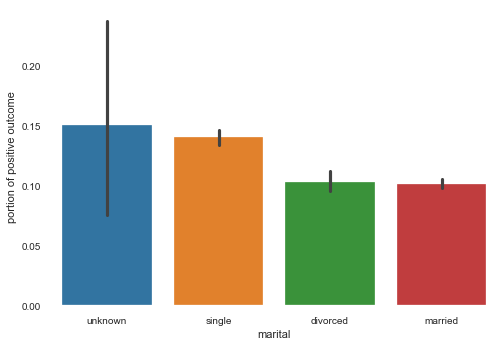

In [2618]:
sns_plot=sns.barplot(x='marital', y='y', data=df[['marital','y']], order=df[['marital', 'y']].groupby('marital').mean().sort_values(by='y', ascending=False).index.values)
sns_plot.set(ylabel='portion of positive outcome')
plt.show()

In [2619]:
pd.DataFrame(df[['marital','y']].groupby('marital', sort=False).sum())

,y
marital,
married,2531
single,1620
divorced,476
unknown,12


In [2620]:
df['marital'].value_counts()

married     24921
single      11564
divorced     4611
unknown        80
Name: marital, dtype: int64

In [2621]:
df.y.value_counts()

0    36537
1     4639
Name: y, dtype: int64

### Outcome by day of the week

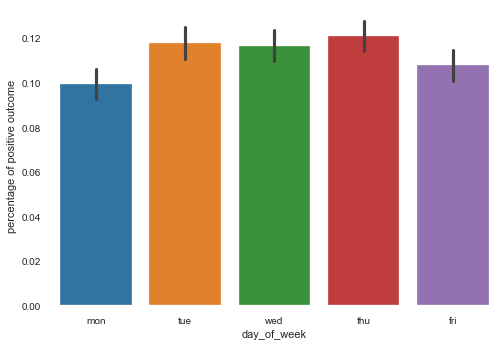

In [2622]:
sns_plot=sns.barplot(x='day_of_week', y='y', data=df[['day_of_week','y']])
sns_plot.set(ylabel='percentage of positive outcome')
plt.show()

### Outcome by age

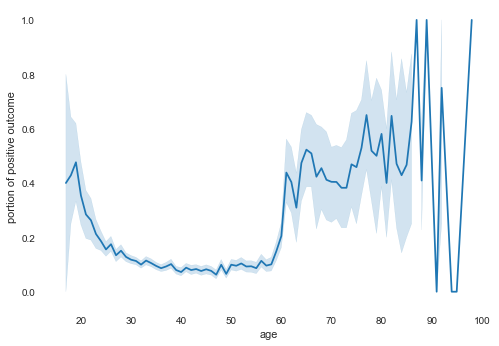

In [2623]:
sns_plot=sns.lineplot(x='age', y='y',palette='tab10', data=df[['age','y']])
sns_plot.set(ylabel='portion of positive outcome')
plt.show()
fig = sns_plot.get_figure()
fig.savefig('/Users/atousachaharsoughshirazi/Capstone_two/figures/outcomebarplotbyage.png') 

The chart above shows that clients younger than 25 and clients older than 60 have a bigger proportion of yes outcome. This is consistent with the result from the ‘Outcome by job’ section above which shows students and retirees have high proportion of yes outcomes.


### Chi-square testing

The table below summarizes the p-values obtained from chi-square testing for each column. If we choose the significance level of ɑ=5%, then only housing and loan, which have p-values larger than 0.05, are not significant. 

In [2624]:
columns=df.drop(['y'], axis=1).columns.values

In [2625]:
dfpval=pd.DataFrame(columns=['Variable', 'p-value', 'p-value>0.05'])

for x in columns:
    obs = list(df[[x,'y']].groupby(x).sum().sort_index().y), list(np.array(df[x].value_counts().sort_index())-np.array(df[[x,'y']].groupby(x).sum().sort_index().y))
    chi2, p, dof, ex=chi2_contingency(obs)
    
    dfpval=dfpval.append({'Variable': x, 'p-value':p, 'p-value>0.05': bool(p>0.05)}, ignore_index=True)
print(dfpval)
dfpval.to_csv(r'/Users/atousachaharsoughshirazi/Capstone_two/figures/pvaluetable.csv')

          Variable        p-value p-value>0.05
0              age  1.803604e-295        False
1              job  3.268412e-199        False
2          marital   1.778423e-26        False
3        education   3.746768e-38        False
4          default   5.217541e-89        False
5          housing   5.663793e-02         True
6             loan   5.771532e-01         True
7          contact  1.718741e-189        False
8            month   0.000000e+00        False
9      day_of_week   3.085755e-05        False
10        campaign   3.988243e-26        False
11           pdays   0.000000e+00        False
12        previous   0.000000e+00        False
13        poutcome   0.000000e+00        False
14    emp.var.rate   0.000000e+00        False
15  cons.price.idx   0.000000e+00        False
16            year   0.000000e+00        False


# 3) Modeling

### Preprocessing

Define X and y, get dummies, scale and split the data set to train and test sets.

In [2626]:
#df=df[df['year']=='2010']
df.drop(['year'], axis=1, inplace=True)

In [2627]:
df=pd.get_dummies(df, drop_first=True)

In [2628]:
y=df['y']
X=df.drop(['y'], axis=1)
scaler = preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X) 
# # # # Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state=42)

Now apply different classification methods.

## Classification methods

The data is imbalanced. Only 11.26% of the data has positive outcome and the rest has a negative outcome. So we use class_weight=’balanced’ in multiple classification methods below.

### Logistic regression

#### No tuning case

In [2629]:
# Create the classifier: logreg
logreg = LogisticRegression(class_weight='balanced')

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy_score(logreg.predict(X_test), y_test)

[[9115 1814]
 [ 486  938]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     10929
           1       0.34      0.66      0.45      1424

    accuracy                           0.81     12353
   macro avg       0.65      0.75      0.67     12353
weighted avg       0.88      0.81      0.84     12353



0.8138104104266171

In [2630]:
report = classification_report(y_test, y_pred, output_dict=True)
dflog = pd.DataFrame(report).transpose()
dflog.to_csv(r'/Users/atousachaharsoughshirazi/Capstone_two/figures/reportlogregnotune.csv')

In [2631]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]

In [2632]:
roc_auc_score(y_test, y_pred_prob)

0.7960640487477395

#### Tuning the parameter

In [2633]:
Cs = [0.001, 0.1, 1, 10, 100]
param_grid = {'C': Cs}
log_cv=GridSearchCV(logreg, param_grid, scoring="roc_auc", cv=5)
log_cv.fit(X_train, y_train)
(log_cv.best_params_, log_cv.best_score_)
# # Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(log_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(log_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 0.1}
Tuned Logistic Regression Accuracy: 0.7897629105299068


In [2634]:
y_pred =log_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[9112 1817]
 [ 486  938]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     10929
           1       0.34      0.66      0.45      1424

    accuracy                           0.81     12353
   macro avg       0.64      0.75      0.67     12353
weighted avg       0.88      0.81      0.84     12353



In [2635]:
y_pred_prob = log_cv.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.7960849960058848

In [2636]:
new_log = LogisticRegression(C=log_cv.best_params_['C'], class_weight='balanced')
new_log.fit(X_train, y_train)
accuracy_score(new_log.predict(X_test), y_test)

0.813567554440217

In [2637]:
y_pred_prob = new_log.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.7960849960058848

#### Tuning the parameter with penalty and a different log space

In [2638]:
c_space = np.logspace(-5, 3, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}
log_cv.fit(X_train, y_train)
# # # Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(log_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(log_cv.best_score_))
# # c_space

Tuned Logistic Regression Parameter: {'C': 0.1}
Tuned Logistic Regression Accuracy: 0.7897629105299068


In [2639]:
accuracy_score(log_cv.predict(X_test), y_test)

0.813567554440217

In [2640]:
# cv_scores = cross_val_score(new_log, X, y, cv=5)
# #cv_scores
# np.mean(cv_scores)

Still the best parameter is C=1

In [2641]:
# m = ols('y ~ age',df).fit()
# print(m.summary())
# plt.scatter(df.y, m.fittedvalues)
# m.fittedvalues

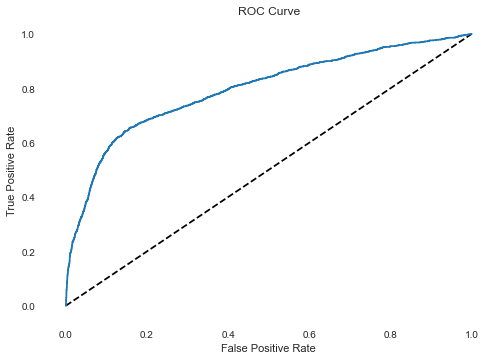

<Figure size 576x396 with 0 Axes>

In [2667]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
#fig = plt_plot.get_figure()
#plt.savefig('/Users/atousachaharsoughshirazi/Capstone_two/figures/roclogreg.png') 

In [2643]:
#roc_auc_score(y_test, y_pred_prob)

In [2644]:
#cv_scores=cross_val_score(new_log, X,y,cv=5, scoring='roc_auc')

In [2645]:
# c_space = np.logspace(-5, 8, 15)
# param_grid = {'C': c_space}
# logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
# logreg_cv.fit(X, y)
# print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
# print("Best score is {}".format(logreg_cv.best_score_))

### Decision Tree

In [2646]:
# param_dist = {"max_depth": [3, None],
#                "max_features": randint(1, 9),
#               "min_samples_leaf": randint(1, 9),
#                "criterion": ["gini", "entropy"]}

# # # Instantiate a Decision Tree classifier: tree
# tree = DecisionTreeClassifier(class_weight='balanced')

# # # Instantiate the RandomizedSearchCV object: tree_cv
# tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# # # Fit it to the data
# tree_cv.fit(X, y)

# # # Print the tuned parameters and score
# print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
# print("Best score is {}".format(tree_cv.best_score_))


### KNN

In [2647]:
# knn=KNeighborsClassifier(n_neighbors=4)
# knn.fit(X_train, y_train)

In [2648]:
# prediction=knn.predict(X_test)
# knn.score(X_test, y_test)

In [2649]:
# #the default score is R^2
# cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
# cv_scores
# np.mean(cv_scores)

In [2650]:
# steps = [('scaler', StandardScaler()),
#         ('knn', KNeighborsClassifier())]
# pipeline = Pipeline(steps)
# knn_scaled = pipeline.fit(X_train,y_train)
# knn_unscaled = KNeighborsClassifier().fit(X_train, y_train)
# print('Accuracy with Scaling: {}'.format(pipeline.score(X_test,y_test)))
# print('Accuracy without Scaling: {}'.format(knn_unscaled.score(X_test,y_test)))

### LASSO

In [2651]:
# lasso = Lasso(alpha=0.9, normalize=False)
# lasso_coef = lasso.fit(X,y).coef_
# lasso_coef

In [2652]:
# X_columns=X.columns
# X_columns

In [2653]:
# Plot the coefficients
# plt.plot(range(len(X_columns)), lasso_coef)
# plt.xticks(range(len(X_columns)),X_columns, rotation=60)
# plt.margins(0.02)
# plt.show()

### Ridge

In [2654]:
# ridge=Ridge(alpha=0.1, normalize=True)
# ridge.fit(X_train, y_train)
# ridge.predict(X_test)
# ridge.score(X_test,y_test)

### SVC

In [2655]:
#cls=SVC()

In [2656]:
#cls.fit(X_train, y_train)

In [2657]:
#cls.predict(X_test)
#cls.score(X_test,y_test)

In [2658]:
#np.mean(X)

In [2659]:
#X_scaled=scale(X)
#np.mean(X_scaled)

In [2660]:
#np.std(X_scaled)

In [2661]:
# # Setup the pipeline
# steps = [('scaler', StandardScaler()),
#          ('SVM', SVC())]

# pipeline = Pipeline(steps)

# # Specify the hyperparameter space
# parameters = {'SVM__C':[1, 10, 100],
#               'SVM__gamma':[0.1, 0.01]}

# # Create train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# # Instantiate the GridSearchCV object: cv
# cv = GridSearchCV(pipeline, param_grid=parameters)

# # Fit to the training set
# cv.fit(X_train, y_train)

# # Predict the labels of the test set: y_pred
# y_pred = cv.predict(X_test)

# # Compute and print metrics
# print("Accuracy: {}".format(cv.score(X_test, y_test)))
# print(classification_report(y_test, y_pred))
# print("Tuned Model Parameters: {}".format(cv.best_params_))